In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import pandas as pd
import copy

from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from rdkit import Chem
from conf_ensemble_dataset_in_memory import ConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from collections import defaultdict
from litschnet import LitSchNet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from rmsd_predictor_evaluator import RMSDPredictorEvaluator
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# Data preparation

In [3]:
data_dir = 'data/'

In [4]:
# run once to preprocess datasets and generate chunks
# dataset = ConfEnsembleDataset()
# dataset = ConfEnsembleDataset(dataset='platinum') # 16G

In [5]:
pdbbind_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('pdbbind')]
pdbbind_n_chunks = len(pdbbind_chunks)

In [6]:
platinum_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('platinum')]
platinum_n_chunks = len(platinum_chunks)

In [7]:
iteration = 0
with open(os.path.join(data_dir, 'scaffold_splits', f'train_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]

with open(os.path.join(data_dir, 'scaffold_splits', f'val_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    val_smiles = f.readlines()
    val_smiles = [smiles.strip() for smiles in val_smiles]

with open(os.path.join(data_dir, 'scaffold_splits', f'test_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]

In [8]:
litschnet = LitSchNet()

In [9]:
optimizer = torch.optim.Adam(litschnet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [10]:
experiment_name = f'scaffold_split_{iteration}_new'
log_dir = os.path.join('logs', experiment_name)
writer = SummaryWriter(log_dir=log_dir)

In [11]:
train_datasets = []
val_datasets = []
test_datasets = []

for chunk_number in tqdm(range(pdbbind_n_chunks)) :

    dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                  smiles_list=train_smiles)
    train_datasets.append(dataset)
    
    dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                  smiles_list=val_smiles)
    val_datasets.append(dataset)
    
    dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                  smiles_list=test_smiles)
    test_datasets.append(dataset)

100%|█████████████████████████████████████████████| 3/3 [03:24<00:00, 68.20s/it]


In [ ]:
def dataset_iteration(epoch, litschnet, optimizer) :
    
    losses = []
    for chunk_number in tqdm(range(pdbbind_n_chunks)) :

        # Load data chunk
        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=train_smiles)
        loader = DataLoader(dataset, 
                            batch_size=64, 
                            shuffle=True, 
                            num_workers=4)

        for batch_idx, batch in (enumerate(loader)) :
            batch.to('cuda')
            optimizer.zero_grad()
            loss = litschnet.training_step(batch, batch_idx)
            loss.backward()
            losses.append(loss.detach().cpu().numpy().item())
            optimizer.step()
    
    return losses

In [10]:
litschnet.to('cuda')
for epoch in range(2) :
    print(f'Epoch {epoch}')
    # Training
    losses = []
    for chunk_number in tqdm(range(pdbbind_n_chunks)) :

        # Load data chunk
        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=train_smiles)
        loader = DataLoader(dataset, 
                            batch_size=64, 
                            shuffle=True, 
                            num_workers=4)

        for batch_idx, batch in (enumerate(loader)) :
            batch.to('cuda')
            optimizer.zero_grad()
            loss = litschnet.training_step(batch, batch_idx)
            loss.backward()
            losses.append(loss.detach().cpu().numpy().item())
            optimizer.step()
    writer.add_scalar("training_loss", np.mean(losses), epoch)
    
    # Validation
    losses = []
    
    litschnet.eval()
    with torch.no_grad() :
        
        for chunk_number in tqdm(range(pdbbind_n_chunks)) :

            # Load data chunk
            dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                              smiles_list=val_smiles)
            loader = DataLoader(dataset, 
                                batch_size=64, 
                                shuffle=False, 
                                num_workers=4)

            for batch_idx, batch in enumerate(loader) :
                batch.to('cuda')
                loss = litschnet.validation_step(batch, batch_idx)
                losses.append(loss.item())
                
    writer.add_scalar("validation_loss", np.mean(losses), epoch)

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Epoch 0


/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/core/lightning.py:420: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  "You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet."
 67%|██████████████████████████████               | 2/3 [00:51<00:25, 25.98s/it]/home/benoit/bioactive_conformation_predictor/litschnet.py:37: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred.squeeze(), target)
  0%|                                                     | 0/3 [00:00<?, ?it/s]

Epoch 1


100%|█████████████████████████████████████████████| 3/3 [01:12<00:00, 24.20s/it]


In [20]:
import importlib
import rmsd_predictor_evaluator
importlib.reload(rmsd_predictor_evaluator)
RMSDPredictorEvaluator = rmsd_predictor_evaluator.RMSDPredictorEvaluator

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Grouping data by smiles



  1%|▌                                          | 5/397 [00:00<00:08, 47.43it/s]

Starting evaluation



100%|█████████████████████████████████████████| 397/397 [00:07<00:00, 54.60it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/core/lightning.py:420: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  "You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet."
 33%|███████████████                              | 1/3 [00:33<01:07, 33.96s/it]

Grouping data by smiles



  1%|▌                                          | 5/415 [00:00<00:09, 44.90it/s]

Starting evaluation



 67%|██████████████████████████████               | 2/3 [01:10<00:35, 35.28s/it]

Grouping data by smiles



  2%|▋                                          | 5/298 [00:00<00:06, 43.43it/s]

Starting evaluation



100%|█████████████████████████████████████████████| 3/3 [01:37<00:00, 32.51s/it]


Mean loss : 0.48


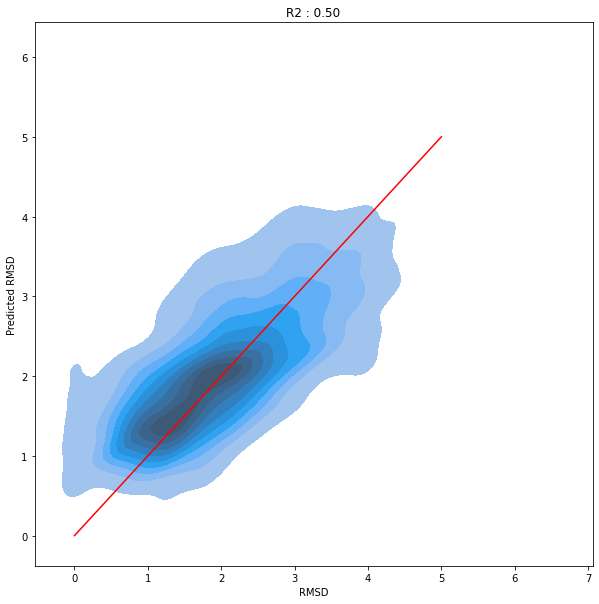

Bioactive ranking accuracy : 0.25279642058165547
Median rank : 8.0


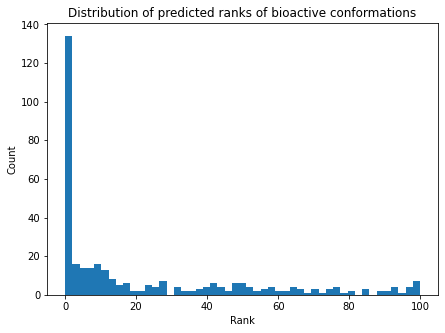

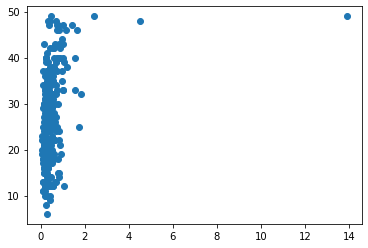

Generated ranking accuracy : 0.10839160839160839
CCDC ranking accuracy : 0.09090909090909091
EF20% prediction : 1.634537493110482
EF20% CCDC : 1.3989646420684578


In [21]:
# PDBBind test
litschnet.eval()
evaluator = RMSDPredictorEvaluator(model=litschnet)

with torch.no_grad() :
    losses = []
    for chunk_number in tqdm(range(pdbbind_n_chunks)) :

        # Load data chunk
        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=test_smiles)
        evaluator.evaluate(dataset)
        loader = DataLoader(dataset, 
                            batch_size=64, 
                            shuffle=True, 
                            num_workers=4)

        for batch_idx, batch in enumerate(loader) :
            batch.to('cuda')
            loss = litschnet.test_step(batch, batch_idx)
            losses.append(loss.item())
    writer.add_scalar("test_loss", np.mean(losses), epoch)
evaluator.evaluation_report()

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Grouping data by smiles



  0%|                                          | 4/4000 [00:00<01:43, 38.75it/s]

Starting evaluation



 50%|██████████████████████▌                      | 1/2 [01:34<01:34, 94.90s/it]

Grouping data by smiles



  1%|▍                                          | 5/548 [00:00<00:11, 47.76it/s]

Starting evaluation



100%|█████████████████████████████████████████████| 2/2 [01:51<00:00, 55.86s/it]


Mean loss : 0.41


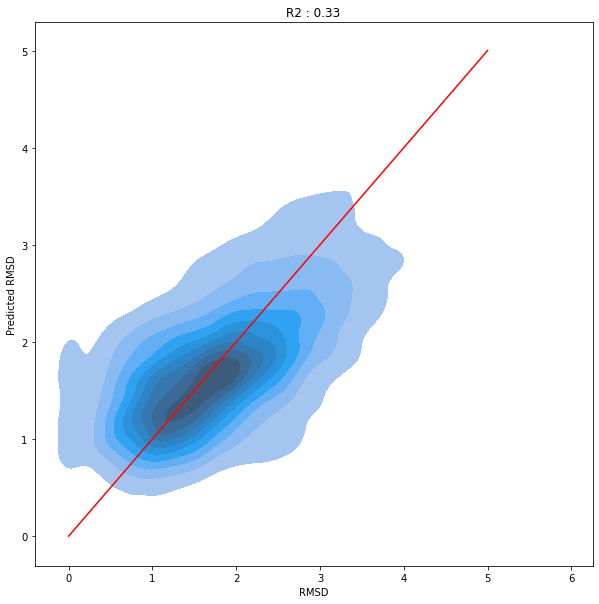

Bioactive ranking accuracy : 0.13138686131386862
Median rank : 17.0


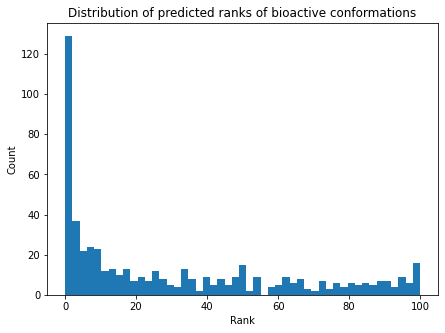

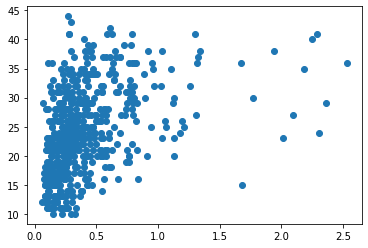

Generated ranking accuracy : 0.08759124087591241
CCDC ranking accuracy : 0.12956204379562045
EF20% prediction : 1.292048385735763
EF20% CCDC : 1.4243859318170005


In [28]:
# Platinum evaluation
litschnet.eval()
evaluator = RMSDPredictorEvaluator(model=litschnet)

with torch.no_grad() :
    for chunk_number in tqdm(range(platinum_n_chunks)) :

        # Load data chunk
        dataset = ConfEnsembleDataset(dataset='platinum',
                                      loaded_chunk=chunk_number)
        evaluator.evaluate(dataset)
    
evaluator.evaluation_report()

In [ ]:
val_dataset = ConfEnsembleDataset(smiles_list=val_smiles)

Loading existing encoders
Chunk num 0 loaded
Chunk num 1 loaded
Chunk num 2 loaded
Chunk num 3 loaded
Chunk num 4 loaded


In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

In [13]:
train_dataset = 5

In [10]:
del train_loader
del train_dataset

In [16]:
from torch.utils.data import ConcatDataset
train_dataset = ConcatDataset(train_datasets)
val_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
experiment_name = f'scaffold_split_{iteration}_new'
if experiment_name in os.listdir('lightning_logs') :
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
else :
    litschnet = LitSchNet()
    logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
    trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
    trainer.fit(litschnet, train_loader, val_loader)
    trainer.test(litschnet, test_loader)

evaluator = RMSDPredictorEvaluator(model=litschnet)
evaluator.evaluate(test_data_list)
#evaluator.evaluate(platinum_subset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
iteration = 0
with open(os.path.join(data_dir, 'scaffold_splits', f'train_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]

with open(os.path.join(data_dir, 'scaffold_splits', f'val_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    val_smiles = f.readlines()
    val_smiles = [smiles.strip() for smiles in val_smiles]

with open(os.path.join(data_dir, 'scaffold_splits', f'test_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]

train_indices = conf_df[conf_df['smiles'].isin(train_smiles)].index
val_indices = conf_df[conf_df['smiles'].isin(val_smiles)].index
test_indices = conf_df[conf_df['smiles'].isin(test_smiles)].index

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

In [ ]:
for iteration in range(2) :
    with open(os.path.join(data_dir, 'scaffold_splits', f'train_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, 'scaffold_splits', f'val_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        val_smiles = f.readlines()
        val_smiles = [smiles.strip() for smiles in val_smiles]

    with open(os.path.join(data_dir, 'scaffold_splits', f'test_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_indices = conf_df[conf_df['smiles'].isin(train_smiles)].index
    val_indices = conf_df[conf_df['smiles'].isin(val_smiles)].index
    test_indices = conf_df[conf_df['smiles'].isin(test_smiles)].index
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'scaffold_split_{iteration}_new'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_subset)
    evaluator.evaluate(platinum_subset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 42


Training: 0it [00:00, ?it/s]

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Process Process-3:
Process Process-2:
Process Process-1:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):


In [ ]:
for iteration in range(2) :
    with open(os.path.join(data_dir, f'train_smiles_random_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, f'val_smiles_random_split_{iteration}.txt'), 'r') as f :
        valid_smiles = f.readlines()
        valid_smiles = [smiles.strip() for smiles in valid_smiles]

    with open(os.path.join(data_dir, f'test_smiles_random_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_indices = conf_df[conf_df['smiles'].isin(train_smiles)].index
    val_indices = conf_df[conf_df['smiles'].isin(val_smiles)].index
    test_indices = conf_df[conf_df['smiles'].isin(test_smiles)].index
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'random_split_{iteration}_new'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_subset)
    evaluator.evaluate(platinum_subset)